Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [1]:
NAME = "Hannah Lange"
COLLABORATORS = ""

---

In [2]:
import tensorflow as tf
from tensorflow.python.keras import Input
from tensorflow.python.keras.engine.functional import Functional
from tensorflow.python.keras.engine.keras_tensor import KerasTensor
from tensorflow.python.keras.models import Model

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Lambda
from tensorflow.python.keras.utils.np_utils import to_categorical
from tensorflow.keras import backend as K
tf.compat.v1.disable_eager_execution()


# MNIST - Variational Autoencoder
The aim of this exercise is to implement the variational autoencoder and to test it on the polynomial
dataset from the previous exercise sheet.
* Implement the loss function of the variational autoencoder in your previous architecture. To do so complete the functions in the `VAE` class.
* Compare the performance and the latent space representations of the traditional
autoencoder and your variational autoencoder. You can use the plotting functions we provided you with.
* (optional, not graded) There is a quicker way of implementing the variational autoencoder using the
tensorflow probability package. Using this package implement your variational autoencoder.


In [3]:
class MNISTData:
    """Data class already implemented for you and ready to use."""
    def __init__(self, data_fraction=1./10):
        data = mnist
        (self.x_train, self.y_train), (self.x_test, self.y_test) = data.load_data()

        self.get_subset_of_data(data_fraction)

        self.convert_label_to_categorical()
        self.normalize_mnist_images()

        self.reshape_to_color_channel()
        self.flatten_pictures()

    def convert_label_to_categorical(self):
        self.y_train = to_categorical(self.y_train)
        self.y_test = to_categorical(self.y_test)

    def normalize_mnist_images(self):
        self.x_train = self.x_train / 255.0
        self.x_test = self.x_test / 255.0

    def reshape_to_color_channel(self):
        self.x_train = self.x_train[:, :, :, np.newaxis]
        self.x_test = self.x_test[:, :, :, np.newaxis]

    def get_subset_of_data(self, data_fraction):
        index = int(len(self.x_train) * data_fraction)
        self.x_train = self.x_train[:index]
        self.y_train = self.y_train[:index]
        index = int(len(self.x_test) * data_fraction)
        self.x_test = self.x_test[:index]
        self.y_test = self.y_test[:index]

    def flatten_pictures(self):
        self.x_train = self.x_train.reshape(self.x_train.shape[0], -1)
        self.x_test = self.x_test.reshape(self.x_test.shape[0], -1)


In [4]:
class Autoencoder:
    """This is the class from last sheets exercise, so there is nothing to do for you here."""
    
    def __init__(self, data: MNISTData, num_classes=10):
        self.x_train = data.x_train
        self.x_test = data.x_test
        self.y_train = data.y_train
        self.y_test = data.y_test

        self.num_classes = num_classes
        self.input_shape = self.x_train[0].shape
        self.input = Input(shape=self.input_shape)

        self.encoder = None
        self.encoder_model = None
        self.decoder = None
        self.autoencoder = None

    def build_encoder(self):
        """Building the encoder architecture and storing the output in self.encoder. 
        The final encoding dimension is 2. """
        
        self.encoder = Dense(128, activation='relu')(self.input)
        self.encoder = Dense(64, activation='relu')(self.encoder)
        self.encoder = Dense(2, activation='relu')(self.encoder)
        
        #building a model for the encoder in order to be able to predict and plot the latent dimension
        self.encoder_model = Model(self.input, self.encoder)
        

    def build_decoder(self):
        """Building the decoder architecture and storing the output in self.decoder. 
        """
        
        if self.encoder is None:
            raise RuntimeError("The encoder has to be built before you can build the decoder!")
        self.decoder = Dense(64, activation='relu')(self.encoder)
        self.decoder = Dense(128, activation='relu')(self.decoder)
        self.decoder = Dense(784, activation='sigmoid')(self.decoder)
        


    def build_autoencoder(self, use_latent_classifier=False):
        """ Building the whole autoencoder Model from self.encoder and self.decoder with self.input as input. 
        """
       
        if self.encoder is None:
            raise RuntimeError("The encoder has to be built before you can build the autoencoder!")
        if self.decoder is None:
            raise RuntimeError("The decoder has to be built before you can build the autoencoder!")

        if use_latent_classifier:
            if self.latent_classifier is None:
                raise RuntimeError("If you want to use the option with the latent classifier, you have to build it "
                                   "beforehand!")
            self.autoencoder = Model(self.input, outputs=[self.decoder, self.latent_classifier])
            self.autoencoder.compile(loss=['mse', 'categorical_crossentropy'], loss_weights=[1, 0.1], optimizer='adam',
                                     metrics="accuracy")
        else:
            self.autoencoder = Model(self.input, outputs=self.decoder)
            self.autoencoder.compile(loss='mse', optimizer='adam')
        

    def fit_data(self, batch_size=128, epochs=20, use_latent_classifier=False):
        """Write the fit function for the autoencoder. 
        Make sure to adapt the fit, if use_latent_classifier is True.
        Store the fit history in self.history to be able to plot the fitting scores."""
        self.history = self.autoencoder.fit(self.x_train, self.x_train, validation_data=(self.x_test, self.x_test),
                                                batch_size=batch_size, epochs=epochs,
                                                shuffle=True,
                                                )
        self.history = self.history.history
        
    



    def plot_score(self, model_name=None):
        """Plots the scores achieved during the fitting.
        """
        plt.plot(self.history['loss'])
        plt.plot(self.history['val_loss'])
        plt.ylabel('Model Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='best')
        if model_name is not None:
            plt.title('Accuracy of {model_name}'.format(model_name=model_name))
        plt.show()

    def plot_latent_dimension(self):
        """Plots the latent dimension of the autoencoder.
        """
        prediction = self.encoder_model.predict(self.x_test)
        fig = plt.figure(figsize=(10, 10))
        fig.patch.set_facecolor("white")
        plt.scatter(prediction[:, 0], prediction[:, 1], c=np.argmax(self.y_test, axis=1), cmap="Set3")
        plt.legend()
        plt.show()

In [5]:
class VAE:
    def __init__(self, data: MNISTData, num_classes=10):
        self.x_train = data.x_train
        self.x_test = data.x_test
        self.y_train = data.y_train
        self.y_test = data.y_test

        self.num_classes = num_classes
        self.input_shape = self.x_train[0].shape
        self.input = Input(shape=self.input_shape)

        self.encoder = None
        self.encoder_model = None
        self.decoder = None
        self.VAE = None
        self.encoded_mean = None
        self.encoded_var = None
    
    def build_encoder(self):
        """Build the encoder architecture for the variational autoencoder and store the output in self.encoder. 
        Store mean and variance of the latent dimension in self.encoded_mean and self.encoded_var.
        The final encoding dimension should be 2. 
        """
        # YOUR CODE HERE
        
        latent_dim = 2
        intermediate_layer = Dense(512, activation='relu')(self.input)
        intermediate_layer = Dense(128, activation='relu')(intermediate_layer)
        intermediate_layer = Dense(64, activation='relu')(intermediate_layer)
        self.encoded_mean  = Dense(latent_dim, name='z_mean')(intermediate_layer)
        self.encoded_var   = Dense(latent_dim, name='z_log_var')(intermediate_layer)
        self.encoder       = Lambda(self.sampling, output_shape = (latent_dim, ), name="z")([self.encoded_mean, self.encoded_var])
        #building a model for the encoder in order to be able to predict and plot the latent dimension
        self.encoder_model = Model(self.input, [self.encoded_mean, self.encoded_var, self.encoder])
        
       

    def build_decoder(self):
        """Build your decoder architecture and store the output in self.decoder. Use self.encoder as 
        input but make sure to catch the error if the encoder model has not been built yet.
        (Hint: the original data is of dimension (None, 784))"""
        # YOUR CODE HERE
        intermediate_layer = Dense(64, activation='relu')(self.encoder)
        intermediate_layer = Dense(128, activation='relu')(intermediate_layer)
        intermediate_layer = Dense(512, activation='relu')(intermediate_layer)
        self.decoder       = Dense(self.input_shape[0], activation='sigmoid')(intermediate_layer)
        
        
    def build_vae(self, use_latent_classifier=False):
        """ Build the whole variational autoencoder Model from self.encoder and self.decoder with 
        self.input as input. Make sure to use self.custom_loss as the model loss function.
        Make sure to catch the error if the encoder or decoder model has not been built yet. 
        """
        # YOUR CODE HERE
        if self.encoder is None:
            raise RuntimeError("The encoder has to be built before you can build the autoencoder!")
        if self.decoder is None:
            raise RuntimeError("The decoder has to be built before you can build the autoencoder!")

        self.VAE = Model(self.input, self.decoder)
        self.VAE.compile(optimizer='adam', loss=self.custom_loss(self.encoded_mean, self.encoded_var))
        
    
    def sampling(self, args):
        """ Implement the Reparameterization trick as shown in the lecture. The function should return
        the a vector randomly sampled from the latent space.
         # Arguments
        args (tensor): mean and log of variance of Q(z|X)

        # Returns
            z (tensor): sampled latent vector   
        """
        # YOUR CODE HERE
        mu, sigma = args
        batch     = K.shape(mu)[0]
        dim       = K.int_shape(mu)[1]
        eps       = K.random_normal(shape=(batch, dim))
        return mu + K.exp(sigma / 2) * eps
    
    

    def custom_loss(self, mean, var):
        """Implement the loss function for the variational autoencoder as shown in the lecture."""       
        def loss(y_true, y_pred):
            # YOUR CODE HERE
            reconstruction_loss = K.sum(K.binary_crossentropy(y_true, y_pred), axis = -1)
            kl_loss = - 0.5* K.sum(1 + var - K.square(mean) - K.exp(var), axis=-1)
            full_loss = K.mean(reconstruction_loss + kl_loss)
            return full_loss        
        return loss
        
        
    def fit_data(self, batch_size=128, epochs=20, use_latent_classifier=False):
        """Write the fit function for the autoencoder. 
        Store the fit history in self.history to be able to plot the fitting scores."""
        

        self.history = self.VAE.fit(self.x_train, self.x_train, validation_data=(self.x_test, self.x_test),
                                                batch_size=batch_size, epochs=epochs,
                                                shuffle=True,
                                                )
        
        self.history = self.history.history
    
    def plot_score(self, model_name=None):
        """Plots the scores achieved during the fitting.
        Just for your convenience, nothing to do for you here."""
        plt.plot(self.history['loss'])
        plt.plot(self.history['val_loss'])
        plt.ylabel('Model Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='best')
        if model_name is not None:
            plt.title('Accuracy of {model_name}'.format(model_name=model_name))
        plt.show()

    def plot_latent_dimension(self):
        """Plots the latent dimension of the autoencoder.
        Nothing to do for you here."""
        prediction = self.encoder_model.predict(self.x_test)
        fig = plt.figure(figsize=(10, 10))
        fig.patch.set_facecolor("white")
        plt.scatter(prediction[2][:, 0], prediction[2][:, 1], c=np.argmax(self.y_test, axis=1), cmap="Set3")
        plt.show()

In [6]:
# your code will be autograded here

In [7]:
# your code will be autograded here


In [8]:
# your code will be autograded here

In [9]:
# your code will be autograded here

In [10]:
# your code will be autograded here

In [11]:
# your code will be autograded here




In [12]:
# your code will be autograded here

Train on 6000 samples, validate on 1000 samples
Epoch 1/20
4352/6000 [====================>.........] - ETA: 0s - loss: 0.1486WARNING:tensorflow:From C:\ProgramData\Miniconda3\envs\MLinPhysics38\lib\site-packages\tensorflow\python\keras\engine\training_v1.py:2048: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
6000/6000 [==============================] - 0s 28us/sample - loss: 0.1282 - val_loss: 0.0708
Epoch 2/20
6000/6000 [==============================] - 0s 22us/sample - loss: 0.0720 - val_loss: 0.0688

No handles with labels found to put in legend.


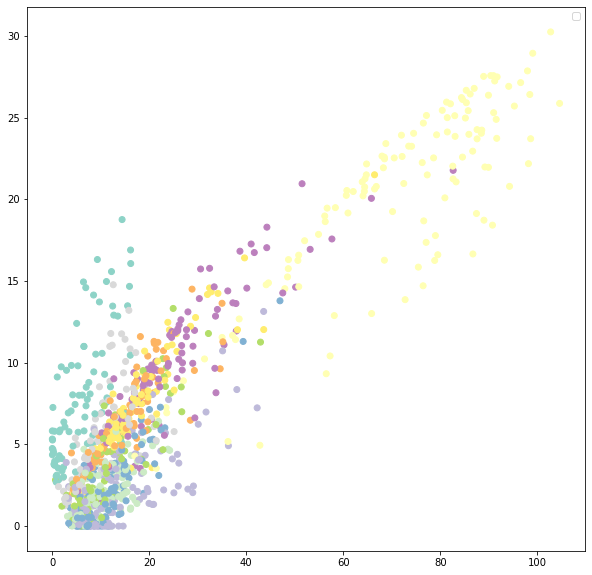

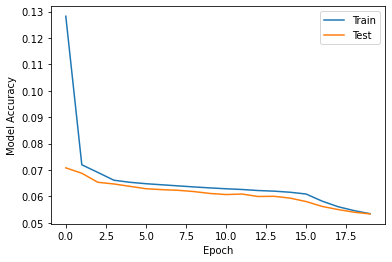

In [13]:
data = MNISTData()

AE = Autoencoder(data)
AE.build_encoder()
AE.build_decoder()
AE.build_autoencoder()
AE.fit_data()
AE.plot_latent_dimension()
AE.plot_score()

Train on 6000 samples, validate on 1000 samples
Epoch 1/20
6000/6000 [==============================] - 0s 66us/sample - loss: 279.7444 - val_loss: 202.1338
Epoch 2/20
6000/6000 [==============================] - 0s 63us/sample - loss: 201.4807 - val_loss: 191.5962

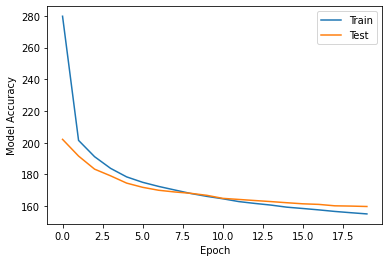

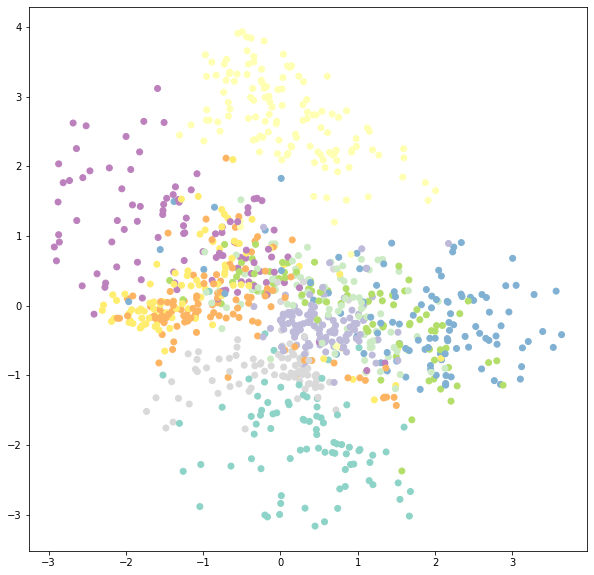

In [14]:
data = MNISTData()

network = VAE(data)
network.build_encoder()
network.build_decoder()
network.build_vae()
network.fit_data()
network.plot_score()
network.plot_latent_dimension()


In [15]:
# cells for implementing the VAE using tensorflow probability package


In [16]:
# cells for implementing the VAE using tensorflow probability package

In [17]:
# cells for implementing the VAE using tensorflow probability package